## Temat projektu: Explainable AI w rozpoznawaniu syntetycznych twarzy
---
### Cel 1: Klasyfikacja obrazów twarzy fake/real z bardzo dużą dokładnością przez model CNN

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


### Task 1: Zbudowanie modelu CNN

 - zdefiniowanie architektury konwolucyjnej sieci neuronowej (CNN) odpowiedniej do binarnej klasyfikacji obrazów twarzy
 - model powinien zawierać warstwy konwolucyjne, poolingowe i gęste
 - do rozwarzenia model ResNet18


In [10]:
import os
from pathlib import Path
import datetime

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from torchmetrics.classification import (
    BinaryPrecision,
    BinaryRecall,
    BinaryAUROC
)

from torch.utils.tensorboard import SummaryWriter

In [12]:
# 2. Device CPU/GPU + wymuszenie inicjalizacji CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# wymuszenie inicjalizacji CUDA
if device.type == "cuda":
    _ = torch.zeros(1, device=device)
    print(torch.cuda.get_device_name(0))

Using device: cuda
NVIDIA GeForce RTX 2070 with Max-Q Design


In [63]:
# 3. Transforms i dane (zamiennik dla ImageDataGenerator z Keras)
IMAGE_SIZE = 128 # docelowo 224 dla lepszych rezultatów z ResNet18, 128 dla szybszych testów
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [64]:
precision = BinaryPrecision().to(device)
recall = BinaryRecall().to(device)
auc = BinaryAUROC().to(device)

In [65]:
# 4. Dataloader
DATA_DIR = Path("./real-and-fake-detection/real_vs_fake/real-vs-fake")

train_dataset = datasets.ImageFolder(
    root=DATA_DIR / "train",
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=DATA_DIR / "valid",
    transform=val_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("Classes:", train_dataset.classes)


Classes: ['fake', 'real']


### Wykorzystanie ResNet18 do uczenia sieci
ResNet18 jest architekturą konwolucyjnej sieci neuronowej, która należy do rodziny Residual Network, po raz pierwszy użytą w 2015 roku. Kluczową kwestią tej sieci jest zastosowanie połączeń rezydualnych (skip connections), które mają za zadanie rozwiązać problem zanikania gradientu i degradacji jakości przy zwiększaniu głębokości sieci. Bardziej efektywny przepływ gradientów wpływa na lepszy proces uczenia.

ResNet18 składa się z 18 warstw posiadających uczące się parametry. Architektura opiera się na sekwencji warstw konwolucyjnych, po których stosowana jest normalizacja - Batch Normalization oraz funkcje aktywacji. Całość kończy się warstwać Fully Connected odpowiedzialną za klasyfikację. 

Sieć zbudowana jest z BuildingBlocks - bloki rezydualne, z których każdy zawiera:
 - dwie warstwy konwolucyjne, z których każda jest połączona z warstwą normalizacji wsadowej oraz fukcją aktywacji ReLU,
 - połączenie skrótowe, które omija warstwy konwolucyjne i dodaje sygnał wejściowy bezpośrednio do ich wyjścia.

ResNet18 jest często wykorzystywany do transfer learningu (poniższy przykład), gdzie wstępnie wytrenowany model na dużym zbiorze danych może być dostrojony do konkretnych zadań.

Budowa architektury:
 - warstwa wejściowa - przyjmuje obrazy najczęsciej o rozmiarze 224 x 224 piksele, RGB  --> aktualny model przymuje 128 x 128, aby znmiejszyć czas treningu
 - początkowa warstwa konwolucyjna - wykorzystuje kernel o większym rozmiarze i stride do uchwycenia podstawowych cech obrazu
 - ResidualBlocks - osiem kolejno połączonych bloków rezydualnych, z których każdy zawiera dwie warstwy konwolucyjne
 - Global Average Pooling - redukuje wymiary przestrzenne map cech
 - Fully Connected Layer - warstwa w pełni połączona, generuje prawdopodobieństwa klas z wykorzystaniem funkcji softmax.

In [66]:
# 5. Model CNN - wykorzystanie ResNet18
model = models.resnet18(weights="DEFAULT")

# zamiana ostatniej warstwy na binarną, bo taką potrzeba do analizy
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

model = model.to(device)

In [67]:
# 6. Loss, optimizer, scheduler
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

In [49]:
# 7. Metryki - Precision, Recall, AUC
precision = BinaryPrecision().to(device)
recall = BinaryRecall().to(device)
auc = BinaryAUROC().to(device)

In [68]:
# 8. Calbacki
EPOCHS = 20 # 10, 20, --> może kiedyś 40, 50?
PATIENCE = 5 # early stopping patience, 5 epok bez poprawy --> przerwać trening

best_val_auc = 0.0
early_stop_counter = 0

CHECKPOINT_DIR = Path("checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir=log_dir)


### Trenowanie modelu 
Proces uczenia trwał 20 epok, W każdej epoce model przechodził przez fazę treningu i fazę walidacji, po to, żeby na bieżąco oceniać jakość uczenia i kontrolę nad procesem optymalizacji. 

Proces uczenia został uzupełniony o mechanizm zapisu najlepszego modelu oraz wczesnego zatrzymywania. Jeżeli w danej epoce wartość miary AUC na zbiorze walidacyjnym przewyższała aktualny najlepszy wynik, stan modelu był zapisywany jako najlepszy, w przeciwnym przypadku licznik epok był zwiększany bez poprawy. Jeżeli poprawa AUC nie następuje przez kolejne 5 epok, trening miał zostać przerwyany.

In [69]:
from torchmetrics import Accuracy, Precision, Recall, F1Score

# === METRYKI ===
train_accuracy = Accuracy(task="binary").to(device)
val_accuracy = Accuracy(task="binary").to(device)
precision = Precision(task="binary").to(device)
recall = Recall(task="binary").to(device)
f1 = F1Score(task="binary").to(device)

best_val_acc = 0.0
early_stop_counter = 0

for epoch in range(EPOCHS):
    # ===== TRAIN =====
    model.train()
    train_loss = 0.0

    train_accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

    for x, y in train_loader:
        x = x.to(device)
        y = y.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Update metrics
        preds = torch.round(outputs)  # binarnie 0/1
        train_accuracy.update(preds, y)
        precision.update(preds, y)
        recall.update(preds, y)
        f1.update(preds, y)

    train_loss /= len(train_loader)
    train_acc = train_accuracy.compute().item() * 100
    train_prec = precision.compute().item() * 100
    train_rec = recall.compute().item() * 100
    train_f1 = f1.compute().item() * 100

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0

    val_accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.float().to(device).unsqueeze(1)

            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()

            preds = torch.round(outputs)
            val_accuracy.update(preds, y)
            precision.update(preds, y)
            recall.update(preds, y)
            f1.update(preds, y)

    val_loss /= len(val_loader)
    val_acc = val_accuracy.compute().item() * 100
    val_prec = precision.compute().item() * 100
    val_rec = recall.compute().item() * 100
    val_f1 = f1.compute().item() * 100

    scheduler.step(val_loss)

    # ===== LOGGING =====
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)
    writer.add_scalar("Precision/val", val_prec, epoch)
    writer.add_scalar("Recall/val", val_rec, epoch)
    writer.add_scalar("F1/val", val_f1, epoch)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
    )

    # ===== CHECKPOINT =====
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), CHECKPOINT_DIR / "best_model.pt")
        print(f"✅ New best validation accuracy: {val_acc:.2f}% --> saved")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("⛔ Early stopping triggered")
            break

Epoch [1/20] Train Loss: 0.1847, Train Acc: 92.40%, Val Loss: 0.0995, Val Acc: 96.44%
✅ New best validation accuracy: 96.44% --> saved
Epoch [2/20] Train Loss: 0.0713, Train Acc: 97.39%, Val Loss: 0.0649, Val Acc: 97.71%
✅ New best validation accuracy: 97.71% --> saved
Epoch [3/20] Train Loss: 0.0455, Train Acc: 98.32%, Val Loss: 0.0842, Val Acc: 96.75%
Epoch [4/20] Train Loss: 0.0361, Train Acc: 98.68%, Val Loss: 0.0484, Val Acc: 98.33%
✅ New best validation accuracy: 98.33% --> saved
Epoch [5/20] Train Loss: 0.0277, Train Acc: 99.00%, Val Loss: 0.0393, Val Acc: 98.65%
✅ New best validation accuracy: 98.65% --> saved
Epoch [6/20] Train Loss: 0.0243, Train Acc: 99.12%, Val Loss: 0.0465, Val Acc: 98.29%
Epoch [7/20] Train Loss: 0.0206, Train Acc: 99.25%, Val Loss: 0.0782, Val Acc: 97.29%
Epoch [8/20] Train Loss: 0.0180, Train Acc: 99.37%, Val Loss: 0.0524, Val Acc: 98.05%
Epoch [9/20] Train Loss: 0.0160, Train Acc: 99.41%, Val Loss: 0.0368, Val Acc: 98.73%
✅ New best validation accuracy

In [17]:
# 9. Trening
for epoch in range(EPOCHS):
    # ===== TRAIN =====
    model.train()
    train_loss = 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0

    precision.reset()
    recall.reset()
    auc.reset()

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.float().to(device).unsqueeze(1)

            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()

            precision.update(outputs, y)
            recall.update(outputs, y)
            auc.update(outputs, y)

    val_loss /= len(val_loader)
    val_precision = precision.compute().item()
    val_recall = recall.compute().item()
    val_auc = auc.compute().item()

    scheduler.step(val_loss)

    # ===== LOGGING =====
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("AUC/val", val_auc, epoch)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_auc={val_auc:.4f}"
    )

    # ===== CHECKPOINT =====
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        early_stop_counter = 0
        torch.save(model.state_dict(), CHECKPOINT_DIR / "best_model.pt")
        print("✅ Best model saved")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("⛔ Early stopping triggered")
            break


Epoch 1/20 | train_loss=0.1856 | val_loss=0.1209 | val_auc=0.9909
✅ Best model saved
Epoch 2/20 | train_loss=0.0695 | val_loss=0.0820 | val_auc=0.9969
✅ Best model saved
Epoch 3/20 | train_loss=0.0476 | val_loss=0.0539 | val_auc=0.9981
✅ Best model saved
Epoch 4/20 | train_loss=0.0346 | val_loss=0.0521 | val_auc=0.9985
✅ Best model saved
Epoch 5/20 | train_loss=0.0270 | val_loss=0.0735 | val_auc=0.9976
Epoch 6/20 | train_loss=0.0248 | val_loss=0.0476 | val_auc=0.9987
✅ Best model saved
Epoch 7/20 | train_loss=0.0196 | val_loss=0.0394 | val_auc=0.9990
✅ Best model saved
Epoch 8/20 | train_loss=0.0183 | val_loss=0.1118 | val_auc=0.9988
Epoch 9/20 | train_loss=0.0168 | val_loss=0.0341 | val_auc=0.9992
✅ Best model saved
Epoch 10/20 | train_loss=0.0144 | val_loss=0.0288 | val_auc=0.9995
✅ Best model saved
Epoch 11/20 | train_loss=0.0136 | val_loss=0.0335 | val_auc=0.9994
Epoch 12/20 | train_loss=0.0125 | val_loss=0.0379 | val_auc=0.9993
Epoch 13/20 | train_loss=0.0116 | val_loss=0.0331 | v

In [18]:
# 10. Koniec treningu:
writer.close()
print("Training finished.")

Training finished.


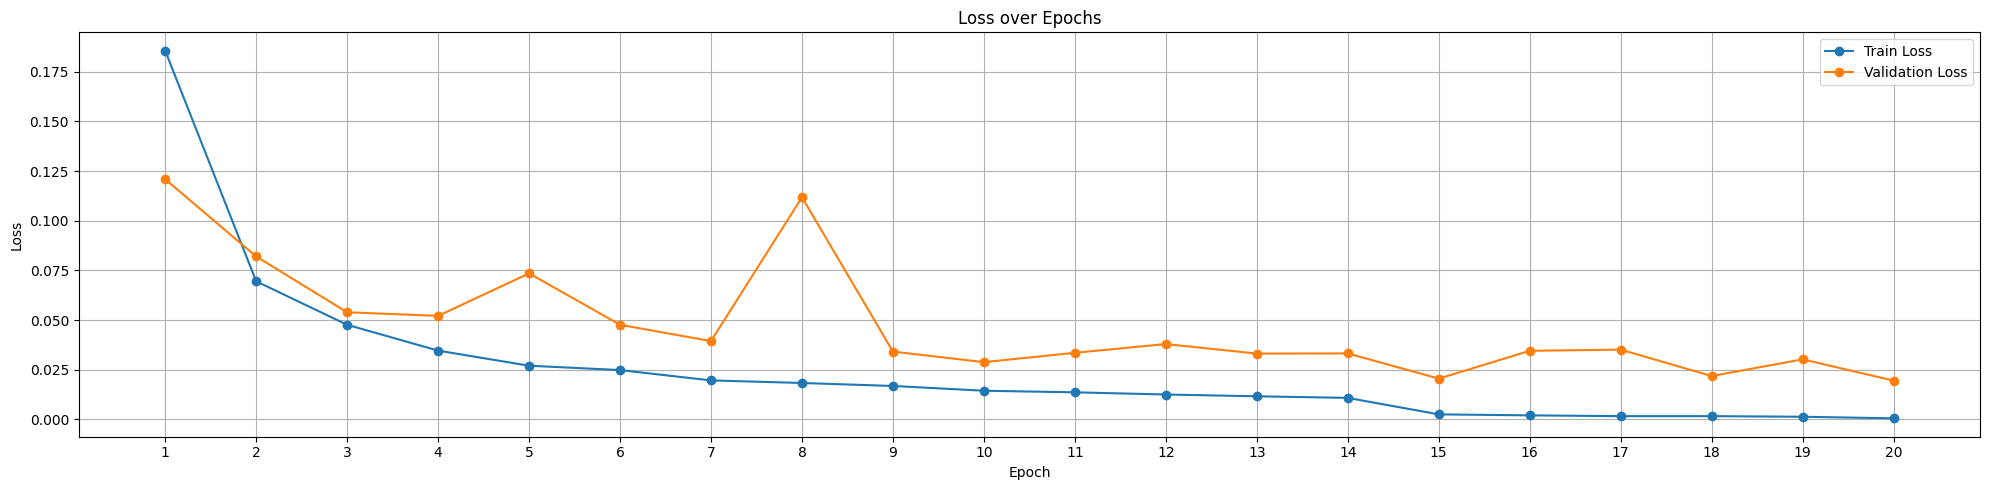

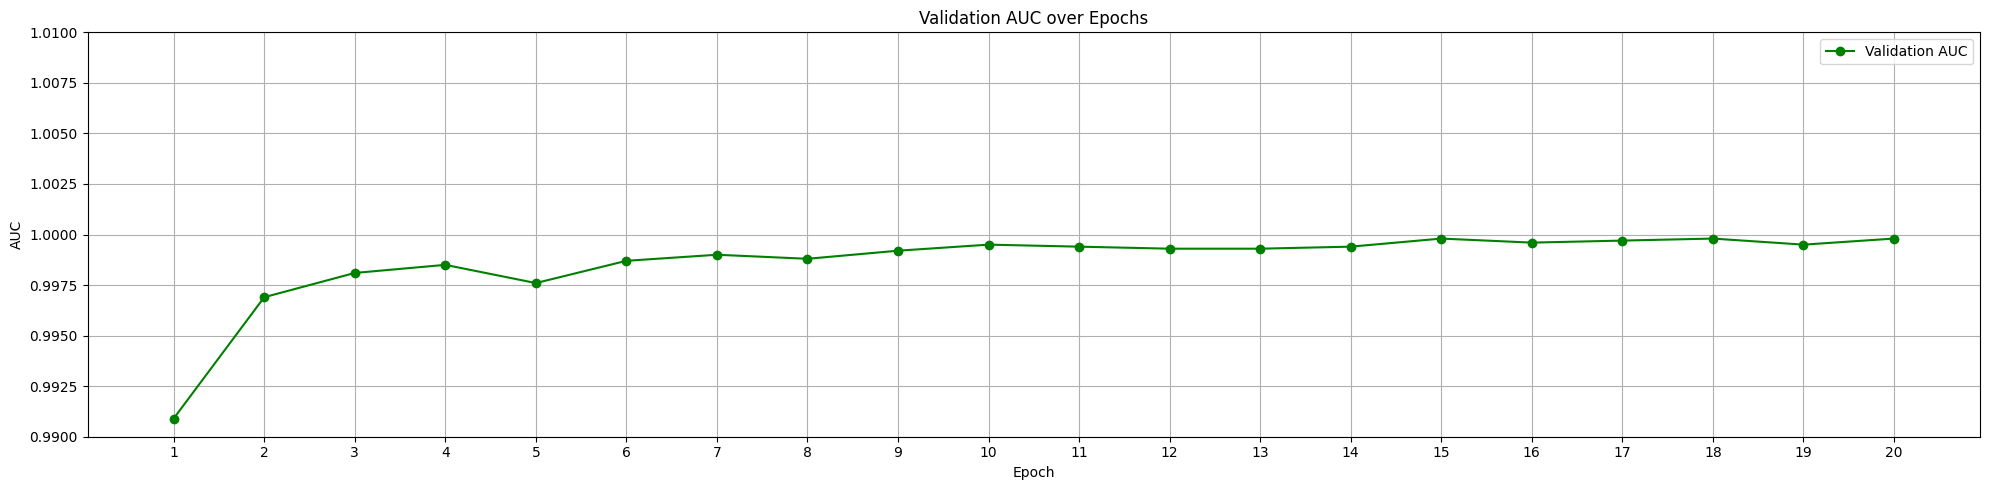

In [6]:
import matplotlib.pyplot as plt
import re

# === 1. Wczytaj dane z pliku results.txt ===
with open("./results.txt", "r") as f:
    lines = f.readlines()

# === 2. Parsowanie danych ===
epochs = []
train_loss = []
val_loss = []
val_auc = []

for line in lines:
    match = re.search(
        r"Epoch (\d+)/\d+ \| train_loss=([0-9.]+) \| val_loss=([0-9.]+) \| val_auc=([0-9.]+)",
        line
    )
    if match:
        epochs.append(int(match.group(1)))
        train_loss.append(float(match.group(2)))
        val_loss.append(float(match.group(3)))
        val_auc.append(float(match.group(4)))

# === 3. Wykres: Loss over epochs ===
plt.figure(figsize=(20,5))
plt.plot(epochs, train_loss, marker='o', label="Train Loss")
plt.plot(epochs, val_loss, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 4. Wykres: Validation AUC over epochs ===
plt.figure(figsize=(20,5))
plt.plot(epochs, val_auc, marker='o', color='green', label="Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Validation AUC over Epochs")
plt.xticks(epochs)
plt.ylim(0.99, 1.01)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
# część druga - ewaluacja modelu na zbiorze testowym
# 1. zładowanie najlepszego modelu
model.load_state_dict(
    torch.load("./checkpoints/best_model.pt", map_location=device)
)
model.eval()
print("Best model loaded for evaluation.")

Best model loaded for evaluation.


In [55]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

IMAGE_SIZE = 128
BATCH_SIZE = 32

test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

In [56]:
# 3. test dataset + loader
TEST_DIR = "./real-and-fake-detection/real_vs_fake/real-vs-fake/test"

test_dataset = ImageFolder(
    root=TEST_DIR,
    transform=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("Classes:", test_dataset.classes)

Classes: ['fake', 'real']


In [57]:
# 4. metryki
from torchmetrics import Accuracy, Precision, Recall, AUROC

test_acc = Accuracy(task="binary").to(device)
test_precision = Precision(task="binary").to(device)
test_recall = Recall(task="binary").to(device)
test_auc = AUROC(task="binary").to(device)

In [58]:
# 5. test loop
test_loss = 0.0
criterion = torch.nn.BCEWithLogitsLoss()

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.float().to(device).unsqueeze(1)

        outputs = model(x)
        loss = criterion(outputs, y)
        test_loss += loss.item()

        test_acc.update(outputs, y)
        test_precision.update(outputs, y)
        test_recall.update(outputs, y)
        test_auc.update(outputs, y)

test_loss /= len(test_loader)

print("===== TEST RESULTS =====")
print(f"Loss:      {test_loss:.4f}")
print(f"Accuracy:  {test_acc.compute().item():.4f}")
print(f"Precision: {test_precision.compute().item():.4f}")
print(f"Recall:    {test_recall.compute().item():.4f}")
print(f"AUC:       {test_auc.compute().item():.4f}")

===== TEST RESULTS =====
Loss:      0.5065
Accuracy:  0.9933
Precision: 0.9950
Recall:    0.9916
AUC:       0.9996


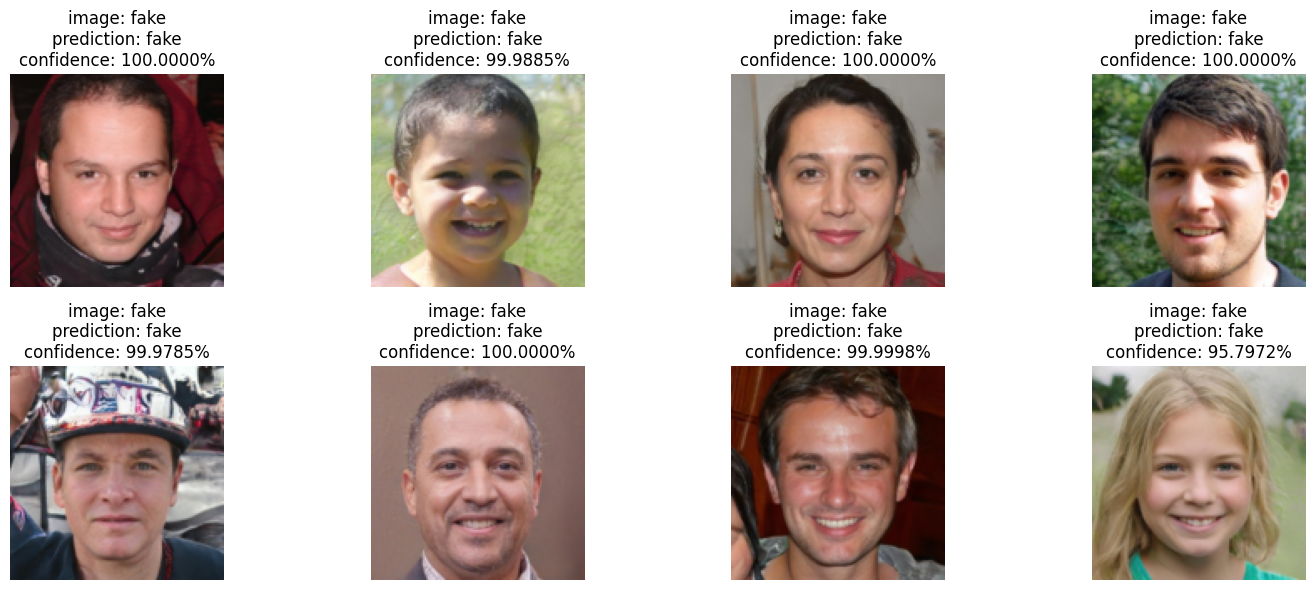

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

model.eval()

# 1. losowe batche
num_samples = 8
images_list, labels_list = [], []

while len(images_list) < num_samples:
    x, y = next(iter(test_loader))  # losowy batch (iterator restartuje się)
    batch_size = x.size(0)
    remaining = num_samples - len(images_list)
    select_n = min(batch_size, remaining)
    indices = random.sample(range(batch_size), select_n)
    
    images_list.append(x[indices])
    labels_list.append(y[indices])

images = torch.cat(images_list, dim=0).to(device)
labels = torch.cat(labels_list, dim=0).to(device).unsqueeze(1)

# 3️. Predykcje modelu
with torch.no_grad():
    outputs = model(images)
    preds = (outputs > 0.5).float()
    confidences = torch.where(preds==1, outputs, 1 - outputs)

# 4️. Przeniesienie do CPU do wyświetlenia
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()
confidences = confidences.cpu()

# 0/1 -> fake/real
def label_to_text(label):
    return "real" if label == 1 else "fake"


# 5️. Wyświetlenie
fig, axes = plt.subplots(2, 4, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img = images[i].permute(1, 2, 0)
    img = (img * 0.5 + 0.5).numpy()

    gt_text = label_to_text(int(labels[i].item()))
    pred_text = label_to_text(int(preds[i].item()))
    conf_text = f"{confidences[i].item() * 100:.4f}%"

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"image: {gt_text}\nprediction: {pred_text}\nconfidence: {conf_text}")

plt.tight_layout()
plt.show()


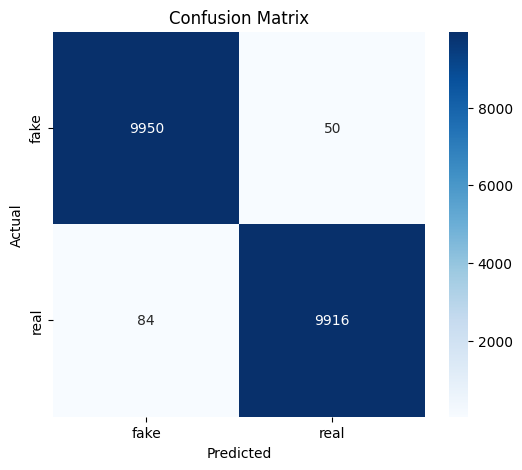

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1)

        outputs = model(x)  # outputs już po Sigmoid
        preds = (outputs > 0.5).float()

        all_labels.append(y.cpu())
        all_preds.append(preds.cpu())

# Połącz wszystko w jedną tablicę
all_labels = torch.cat(all_labels, dim=0).numpy()
all_preds = torch.cat(all_preds, dim=0).numpy()

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Wyświetlenie ładnej mapy cieplnej
labels_text = ["fake", "real"]
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels_text, yticklabels=labels_text)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()